In [1]:
import random
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Disable GPU (doesn't work for LSTMs)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import tensorflow

In [4]:
import keras
from keras.models import Model, Input, load_model, Sequential
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed, Reshape, multiply, Permute, Lambda
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


In [5]:
# for pretty printing table
pandas_table = pd.option_context('display.max_rows', None, 'display.max_columns', None)
# increased font size for thesis plots
plt.rcParams.update({'font.size': 15})
# set a good figure size for the paper
figsize = (13,7)
set_figsize = lambda: plt.figure(figsize=(13,7))
savefig = lambda x: plt.savefig(os.path.join('figures', x), bbox_inches = "tight")

Create training set of random numbers between 0 and 10

In [6]:
X_train_no_mask = np.array([[[random.randrange(0,10), 1] for y in range(random.randrange(1,10))] for x in range(1000)])
X_train = np.array([x + [[0, 0]] * (10 - len(x)) for x in X_train_no_mask]) # pad to 10

In [7]:
X_train.shape

(1000, 10, 2)

In [8]:
Y_train = np.array([np.sum(x) for x in X_train])

In [9]:
X_test_no_mask = np.array([[[random.randrange(0,10), 1] for y in range(random.randrange(1,10))] for x in range(1000)])
X_test = np.array([x + [[0, 0]] * (10 - len(x)) for x in X_test_no_mask]) # pad to 10

In [10]:
X_test.shape

(1000, 10, 2)

In [11]:
Y_test = np.array([np.sum(x) for x in X_test])

In [12]:
lstm_units = 128

In [13]:
num_features = X_test.shape[-1]

In [14]:
input_layer = Input(shape=(None, num_features)) 

# set states going into this LSTM application
# in order to use SHAP, need to pass on state
feedin_previous_output = Input(shape=(lstm_units)) 
feedin_cell_state = Input(shape=(lstm_units)) 

x = Masking(mask_value=0)(input_layer)
# x = input_layer
x = LSTM(lstm_units, return_state=True)(x, initial_state=[feedin_previous_output, feedin_cell_state])

# get output from LSTM
output = Lambda(lambda x: x[0])(x)
output = Dense(1)(output) # binary output

# as well as the model output, we want the hidden state output and the cell
# state for later. 
# See https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
lstm_output = Lambda(lambda x: x[0])(x)
cell_state = Lambda(lambda x: x[2])(x)

model = Model(inputs=[input_layer, feedin_previous_output, feedin_cell_state],
              outputs=[output, lstm_output, cell_state])

In [15]:
model.summary()

optimizer = Adam(lr=0.0005, epsilon=1e-08)
# only optimize output from dense layer
model.compile(optimizer, loss=['mean_squared_error', None, None], metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 2)      0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
______________________________________________________________________________________________

In [16]:
def model_predict(x, h=None, c=None, state=False):
    """Wrapper function for running model predictions. 
    
    h: Input to the model, corresponds with `feedin_previous_output`.
        Set to None for default initialization
        
    c: Input to the model, corresponds with `feedin_cell_state`.
        Set to None for default initialization
        
    state: If True, return the state from the model. Otherwise, just return output.
    
    Returns: model output
    """
    
    if h is None:
        h = np.zeros((len(x), lstm_units))
        
    if c is None:
        c = np.zeros((len(x), lstm_units))

    if state:
        return model.predict([x, h, c])
    return model.predict([x, h, c])[0]

def model_evaluate(x, y):
    """Wrapper function to evaluate model accuracy on x and y. Returns loss."""
    
    return model.evaluate(x=[x, np.zeros((len(x), lstm_units)), np.zeros((len(x), lstm_units))],
                          y=y, verbose=False)[1]

In [17]:
model.fit(x=[X_train, np.zeros((len(X_train), lstm_units)), np.zeros((len(X_train), lstm_units))],
          y=Y_train, epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 8ms/step - loss: 876.5602 - dense_loss: 876.5602 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0080
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 563.6995 - dense_loss: 563.6995 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0120 - lambda_2_acc: 0.0100
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 370.1325 - dense_loss: 370.1325 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0200 - lambda_2_acc: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 290.7005 - dense_loss: 290.7005 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0180 - lambda_2_acc: 0.0030
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 241.0589 - dense_loss: 241.0589 - dense_acc: 0.0110 - lambda_1_acc: 0.0090 - lambda_2_acc: 0.0030
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 204.8810 - dense_loss: 204.8810 - dense_acc: 0.0

32/32 [==============================] - 0s 7ms/step - loss: 0.8401 - dense_loss: 0.8401 - dense_acc: 0.0190 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 94/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7900 - dense_loss: 0.7900 - dense_acc: 0.0190 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 95/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8396 - dense_loss: 0.8396 - dense_acc: 0.0190 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 96/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8497 - dense_loss: 0.8497 - dense_acc: 0.0190 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 97/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7149 - dense_loss: 0.7149 - dense_acc: 0.0190 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 98/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7244 - dense_loss: 0.7244 - dense_acc: 0.0190 - lambda_1_

In [18]:
model_evaluate(X_train, Y_train)

0.6217483878135681

In [19]:
model_predict(X_train[4:5])

array([[48.942665]], dtype=float32)

In [20]:
X_train[4:5]

array([[[0, 1],
        [4, 1],
        [8, 1],
        [1, 1],
        [7, 1],
        [7, 1],
        [4, 1],
        [1, 1],
        [8, 1],
        [0, 0]]])

In [21]:
np.sum(X_train[4:5])

49

In [22]:
Y_train[4]

49

In [23]:
model_evaluate(X_test,Y_test)

1.050095796585083

## Old SHAP

In [24]:
sys.path.append(os.path.join('../..', 'shap'))
import shap as shap

shap.initjs()

In [25]:
def predict(X, **kwargs):
    X = X.reshape((-1,1,num_features))
    return model_predict(X).flatten()

In [26]:
flatten = lambda lst: np.array([x for y in lst for x in y])

In [27]:
all_data = flatten(X_test_no_mask) # X_test_no_mask

In [28]:
all_data.shape

(4965, 2)

In [29]:
all_data_summary = shap.kmeans(all_data, 10)

In [30]:
%%time
explainer = shap.KernelExplainer(predict, all_data_summary)
shap_values = explainer.shap_values(all_data)


Wall time: 1min 45s


In [31]:
explainer.expected_value

3.1431863307952876

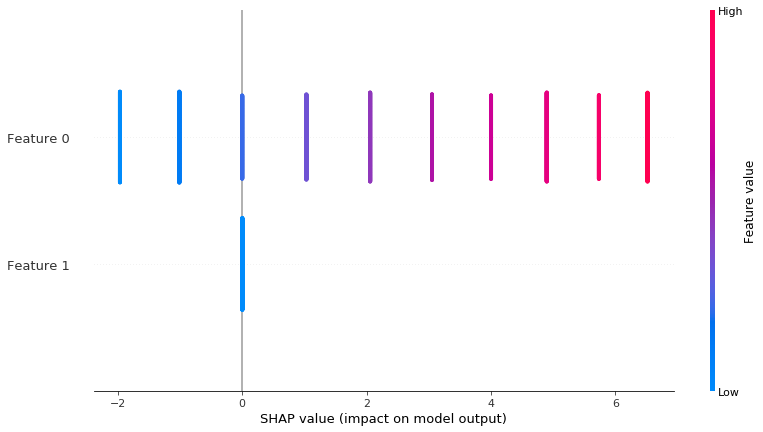

In [32]:
shap.summary_plot(shap_values, all_data, plot_size=figsize, show=False)
savefig('Sanity Old Global')

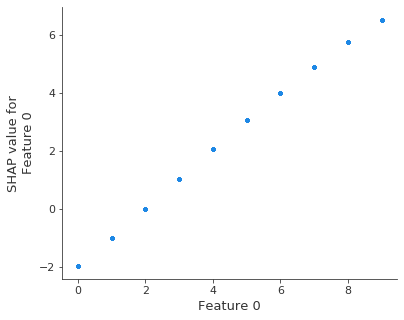

In [66]:
shap.dependence_plot(0, shap_values, features=all_data, interaction_index=None, show=False)
savefig('Sanity Old Global Feature')

In [34]:
sequence_indices = []
temp = 0
for x in [len(x) for x in X_test_no_mask]: # X_test_no_mask
    sequence_indices.append((temp, x+temp))
    temp += x

In [85]:
sl = slice(*sequence_indices[5])
print(all_data[sl])
print(shap_values[sl])
shap.force_plot(explainer.expected_value, shap_values[sl], all_data[sl], show=False)

[[7 1]
 [0 1]
 [7 1]
 [1 1]
 [8 1]
 [1 1]
 [2 1]
 [3 1]
 [7 1]]
[[ 4.89699578e+00  0.00000000e+00]
 [-1.96505320e+00  0.00000000e+00]
 [ 4.89699578e+00  0.00000000e+00]
 [-1.01014447e+00  0.00000000e+00]
 [ 5.73572278e+00  0.00000000e+00]
 [-1.01014447e+00  0.00000000e+00]
 [-2.38418579e-07  0.00000000e+00]
 [ 1.03239226e+00  0.00000000e+00]
 [ 4.89699578e+00  0.00000000e+00]]


In [80]:
shap.force_plot?

## New SHAP

In [36]:
def state_predict(X, internal_state=None):
    """
    internal_state: list of internal states. should be of the form [h, c]
    
    Returns [output, h, c]
    """
    X = X.reshape((-1,1,num_features))
    
    if internal_state:
        h,c = internal_state
        o, nh, nc = model_predict(X, h=h, c=c, state=True)
        return o.flatten(), nh, nc

    o, nh, nc = model_predict(X, state=True)
    return o.flatten(), nh, nc

In [37]:
association = flatten([[i for _ in range(len(x))] for i, x in enumerate(X_test_no_mask)]) # X_test_no_mask

In [38]:
state_explainer = shap.KernelExplainer(state_predict, all_data_summary)
state_shap_values = state_explainer.shap_values(all_data, association=pd.Series(association))

In [39]:
state_explainer.expected_value

5.5478249166187075

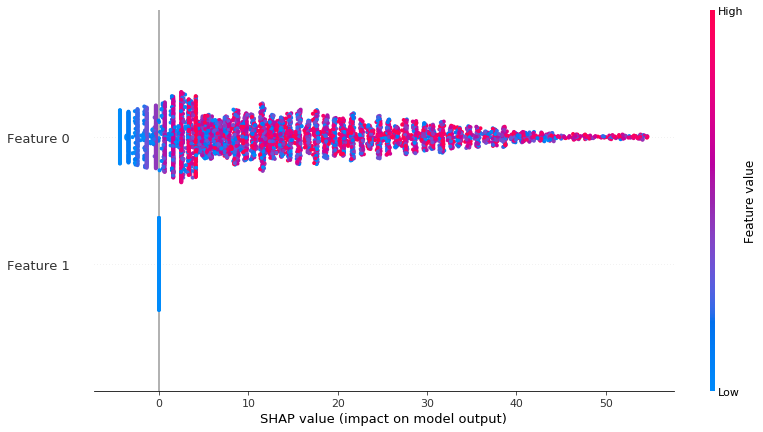

In [69]:
shap.summary_plot(state_shap_values, all_data, plot_size=figsize, show=False)
savefig('Sanity New Global')

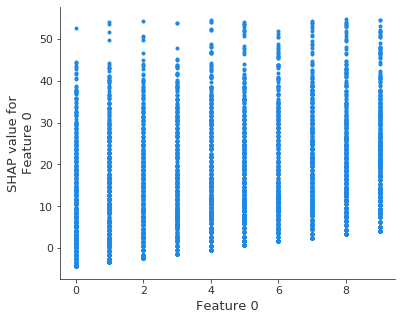

In [71]:
shap.dependence_plot(0, state_shap_values, features=all_data, interaction_index=None, show=False)
savefig('Sanity New Global Feature')

In [86]:
sl = slice(*sequence_indices[5])
print(all_data[sl])
print(state_shap_values[sl])
shap.force_plot(state_explainer.expected_value, state_shap_values[sl], all_data[sl])

[[7 1]
 [0 1]
 [7 1]
 [1 1]
 [8 1]
 [1 1]
 [2 1]
 [3 1]
 [7 1]]
[[ 2.4923572   0.        ]
 [ 3.23937506  0.        ]
 [11.46232981  0.        ]
 [13.56154436  0.        ]
 [22.78289789  0.        ]
 [24.75186914  0.        ]
 [27.68181223  0.        ]
 [31.79191202  0.        ]
 [39.74147409  0.        ]]


## Local accuracy

The model evaluates all elements in the sequence and outputs a single number (the sum of all time series). However, SHAP calculates a shap value for every time step within all sequence. To check if the model output is the same as from SHAP, the last element in the sequence is used. 

`allclose` is used due to floating point accuracy limitations.

In [43]:
preds = model_predict(X_test).flatten()

### Old SHAP

In [44]:
np.allclose([shap_values[slice(*sl)][-1].sum() + explainer.expected_value for sl in sequence_indices], preds)

False

### New SHAP

In [45]:
np.allclose([state_shap_values[slice(*sl)][-1].sum() + state_explainer.expected_value for sl in sequence_indices], preds)

True

## Missingness

LSTMs have some added difficulty in that missing features can be used by the model (e.g. for a model that counts the number of input time steps) and it would be impossible to satisfy this and local accuracy for the addition model. To get around this, a new feature can be made that extracts the importance from the previous application.

However, the notion of missingness doesn't make sense for time series models. For instance, consider a counter model that counts the number of inputs the model has seen.

In [46]:
Y_test[11]

27

In [47]:
preds[11]

27.177017

In [48]:
X_test[11:12]

array([[[5, 1],
        [0, 1],
        [5, 1],
        [4, 1],
        [8, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]])

In [49]:
[model_predict(X_test[11:12,:x])[0][0] for x in range(1, 11)]

[6.1950107,
 6.8508573,
 13.035379,
 18.122345,
 27.177011,
 27.177011,
 27.177011,
 27.177011,
 27.177011,
 27.177011]

In [50]:
state_shap_values[slice(*sequence_indices[11])]

array([[ 0.64718575,  0.        ],
       [ 1.30303234,  0.        ],
       [ 7.48755449,  0.        ],
       [12.57452005,  0.        ],
       [21.62918657,  0.        ]])

## new shap values with offset

In [51]:
new_shap_values = []
for sl in sequence_indices:
    prev_features = None
    for features in state_shap_values[slice(*sl)]:
        if prev_features is None:
            new_shap_values.append([*features, 0])
        else:
            new_shap_values.append([*(features - prev_features), sum(prev_features)])
        prev_features = features
new_shap_values = np.array(new_shap_values)

In [52]:
new_shap_values

array([[-2.40463882,  0.        ,  0.        ],
       [ 5.14670801,  0.        , -2.40463882],
       [ 8.04151917,  0.        ,  2.74206919],
       ...,
       [ 7.03523636,  0.        , 30.78350824],
       [-4.36969179,  0.        ,  0.        ],
       [ 0.74240971,  0.        , -4.36969179]])

In [53]:
new_shap_values[slice(*sequence_indices[11])]

array([[ 0.64718575,  0.        ,  0.        ],
       [ 0.6558466 ,  0.        ,  0.64718575],
       [ 6.18452215,  0.        ,  1.30303234],
       [ 5.08696556,  0.        ,  7.48755449],
       [ 9.05466652,  0.        , 12.57452005]])

In [54]:
# local
np.allclose([new_shap_values[slice(*sl)][-1].sum() + state_explainer.expected_value for sl in sequence_indices], preds)

True

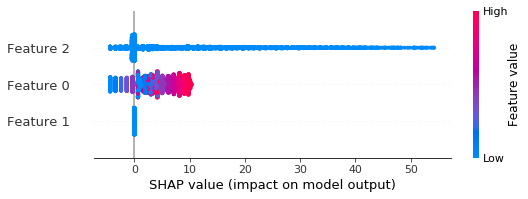

In [55]:
shap.summary_plot(new_shap_values, np.c_[all_data, np.zeros(len(all_data))])

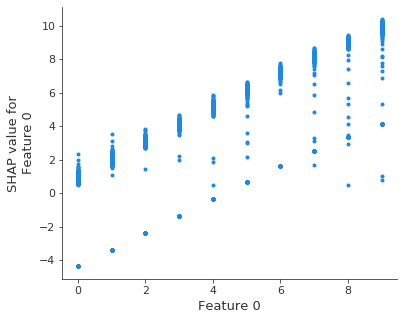

In [56]:
shap.dependence_plot(0, new_shap_values, features=np.c_[all_data, np.zeros(len(all_data))], interaction_index=None)

In [57]:
sl = slice(*sequence_indices[11])
print(all_data[sl])
print(new_shap_values[sl])
shap.force_plot(explainer.expected_value, new_shap_values[sl], np.c_[all_data, np.zeros(len(all_data))][sl])

[[5 1]
 [0 1]
 [5 1]
 [4 1]
 [8 1]]
[[ 0.64718575  0.          0.        ]
 [ 0.6558466   0.          0.64718575]
 [ 6.18452215  0.          1.30303234]
 [ 5.08696556  0.          7.48755449]
 [ 9.05466652  0.         12.57452005]]


## new shap values with offset v2

Instead of the above, how about using normal SHAP but getting a `previous state` score?

E.g. sometimes the LSTM bases it's predictions from something other than the features. For example, a counter model.

In [58]:
explainer.expected_value

3.1431863307952876

In [59]:
offset_shap_values = np.c_[shap_values, state_shap_values.sum(axis=1) + state_explainer.expected_value - (
    shap_values.sum(axis=1) + explainer.expected_value)]

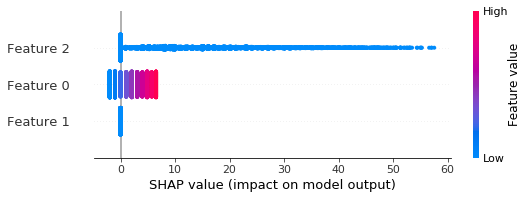

In [60]:
shap.summary_plot(offset_shap_values, np.c_[all_data, np.zeros(len(all_data))])

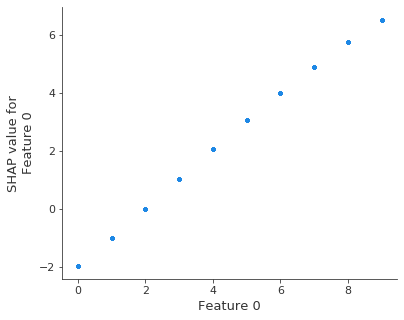

In [61]:
shap.dependence_plot(0, offset_shap_values, features=np.c_[all_data, np.zeros(len(all_data))], interaction_index=None)

In [62]:
sl = slice(*sequence_indices[11])
print(all_data[sl])
print(offset_shap_values[sl])
shap.force_plot(explainer.expected_value, offset_shap_values[sl], np.c_[all_data, np.zeros(len(all_data))][sl])

[[5 1]
 [0 1]
 [5 1]
 [4 1]
 [8 1]]
[[ 3.05182433  0.          0.        ]
 [-1.9650532   0.          5.67272413]
 [ 3.05182433  0.          6.84036875]
 [ 2.05724788  0.         12.92191076]
 [ 5.73572278  0.         18.29810238]]
